In [1]:
import pandas as pd
from datasets import load_dataset, dataset_dict
import gzip
import bz2
import numpy as np
from tqdm import tqdm
import concurrent.futures
from sklearn.model_selection import train_test_split

/home/yvson/Documents/Faculdade/NLP/NLP-final-project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("ag_news")

In [3]:
train , validation = train_test_split(dataset['train'].to_pandas(), test_size=0.065, random_state=42)

In [4]:
def get_balanced_dataset(dataset, percentage):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 
    dataset = pd.DataFrame(dataset)
    dataset = dataset[['text', 'label']]
    dataset = dataset.groupby("label").apply(lambda x: x.sample(frac=percentage)).reset_index(drop=True)
    return dataset

In [5]:
Categories = ["World", "Sports", "Business", "Sci/Tech"]
Categories

['World', 'Sports', 'Business', 'Sci/Tech']

In [12]:
perc_train = 0.14
perc = 0.25

train_df = get_balanced_dataset(train, perc_train)
teste_df = get_balanced_dataset(dataset["test"], perc)
valid_df = get_balanced_dataset(validation, perc)

train_df['Categories'] = train_df['label'].apply(lambda x: Categories[x])

training_set = list(zip(train_df["text"], train_df["label"]))
test_set = list(zip(teste_df["text"], teste_df["label"]))


<Axes: title={'center': 'Distribuição das categorias - Treino AGNews'}, xlabel='Categories'>

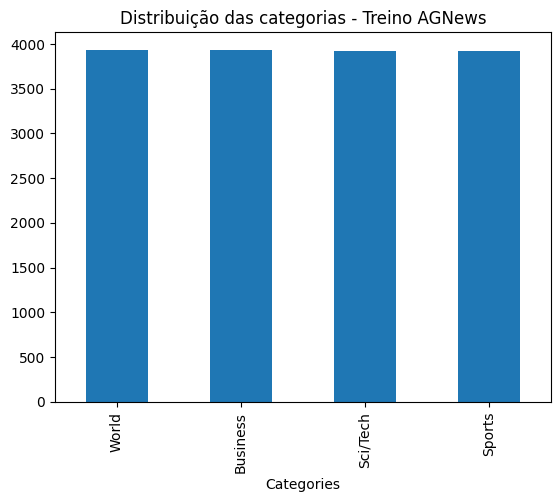

In [13]:
pd.DataFrame(train_df)['Categories'].value_counts().plot(kind='bar', title='Distribuição das categorias - Treino AGNews')

In [75]:
train_df

,text,label
0,Annan: Darfur settlement possible by year end ...,0
1,Philippines Rushes Relief to Flooded Areas GE...,0
2,UK soldier held over Iraq murder A 21-year-old...,0
3,European Envoy Visiting Turkey to Assess Situa...,0
4,Voters in Hungary decide referenda Voters in H...,0
...,...,...
15704,N.Y. Atty General Announces Drug-Price Web Sit...,3
15705,Al Gore Touts Promise of Stem-Cell Research By...,3
15706,IDC: AMD captured 10 percent CPU share Market ...,3
15707,Sharp adds hard disk to its Linux PDA Sharp Co...,3


In [76]:
valid_df

,text,label
0,Accused Air India bomber is a victim of lies: ...,0
1,Quotes From Allawi Speech (AP) AP - Reaction t...,0
2,Darfur peace talks seek to break deadlock on k...,0
3,Newsview: Flawed Candidates Neck and Neck (AP)...,0
4,Up to 30 Militants Killed by Police in Nigeria...,0
...,...,...
1945,Gates to keynote January CES Microsoft head ho...,3
1946,"Allchin: Don't call it ""Shorthorn"" Despite the...",3
1947,ebay Fun and Holy Toast! The Internet megasite...,3
1948,28 Identity Theft Suspects Arrested in Transat...,3


In [77]:
teste_df

,text,label
0,Japan steps up efforts for Iraq hostage releas...,0
1,U.N. War Court Transfers First Case to Serbia ...,0
2,Fallujah Violence Leaves 10 Troops Dead (AP) A...,0
3,Ivory Coast Leader Urges End to Violence ABID...,0
4,Chicoutimi #39;was seaworthy #39; A submarine...,0
...,...,...
1895,Put RSS Feeds On Your Web Page Put RSS Feeds O...,3
1896,AOL Shows Safe Chat Rooms Secure USB tokens us...,3
1897,Intel puts in plug for Linux (SiliconValley.co...,3
1898,Veritas Keeps Reaching into Its Wallet By acqu...,3


In [78]:
training_set = list(zip(train_df["text"], train_df["label"]))
test_set = list(zip(teste_df["text"], teste_df["label"]))

In [79]:
def NDC_gzip(x1,x2):
    Cx1x2 = len(gzip.compress(" ".join([x1 , x2]).encode()))
    Cx1 = len(gzip.compress(x1.encode())) 
    Cx2 = len(gzip.compress(x2.encode()))

    return (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)

def NDC_bz2(x1,x2):
    Cx1x2 = len(bz2.compress(" ".join([x1 , x2]).encode()))
    Cx1 = len(bz2.compress(x1.encode())) 
    Cx2 = len(bz2.compress(x2.encode()))

    return (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)

In [80]:
def split_list(data, n):
    k, m = divmod(len(data), n)
    return [data[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def cal_KNN_NDC(test_set):
    K = 3
    y_hat = []

    for (x1 , _) in tqdm(test_set):
        distances_to_xtest = []
        for (x2 , _) in training_set:
            distances_to_xtest.append(NDC_gzip(x1, x2))
        
        sorted_idx = np.argsort(distances_to_xtest)
        k_nearest = sorted_idx[:K]
        y_hat.append(training_set[max(set(k_nearest), key=k_nearest.tolist().count)][1])

    return y_hat


workers = 12

results = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    splited_data =  split_list(test_set, workers)
    processed = executor.map(cal_KNN_NDC, splited_data)

    for result in processed:
        results.append(result)

y_hat = [item for sublist in results for item in sublist]

100%|██████████| 158/158 [03:22<00:00,  1.28s/it]


In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_test = [y for (_, y) in test_set]

#compute accuracy
accuracy = sum([y_hat[i] == y_test[i] for i in range(len(y_test))]) / len(y_test)
print(f"Accuracy: {accuracy}")

#compute recall
recall = recall_score(y_test, y_hat, average='macro')
print(f"Recall: {recall}")

#compute precision
precision = precision_score(y_test, y_hat, average='macro')
print(f"Precision: {precision}")

#compute f1 score
f1 = f1_score(y_test, y_hat, average='macro')
print(f"F1 Score: {f1}")

Accuracy: 0.783157894736842
Recall: 0.783157894736842
Precision: 0.7833582485719396
F1 Score: 0.7823971636566625


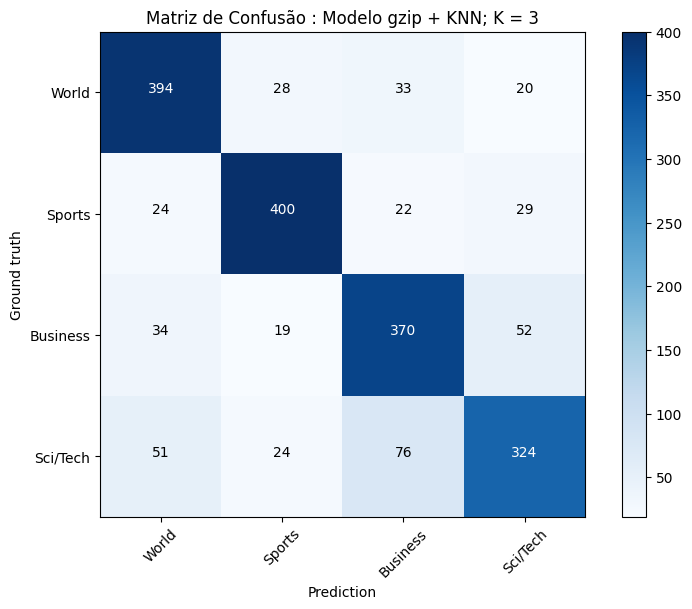

In [82]:
conf_matrix = confusion_matrix(y_test, y_hat)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão : Modelo gzip + KNN; K = 3')
plt.colorbar()


tick_marks = np.arange(len(Categories))
plt.xticks(tick_marks, Categories, rotation=45)
plt.yticks(tick_marks, Categories)


thresh = conf_matrix.max() / 2.
for i, j in [(i, j) for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])]:
    plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Ground truth')
plt.xlabel('Prediction')
plt.show()